In [35]:
import torch
torch.__version__

'2.5.1+cu124'

In [36]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [37]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from mlxtend.plotting import plot_confusion_matrix
import os

## Load Data

In [38]:
class FERDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

        # Ekstrak label dan piksel
        self.labels = self.dataframe['emotion'].values
        self.pixels = self.dataframe['pixel'].apply(self.string_to_image).values

    def string_to_image(self, pixels_string):
        # Konversi string piksel menjadi numpy array dan reshape ke 48x48
        pixels = np.array(pixels_string.split(), dtype='float32')
        image = pixels.reshape(48, 48)
        image = np.expand_dims(image, axis=-1)  # Tambahkan channel dimensi
        return image

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image = self.pixels[idx]
        label = self.labels[idx]
        
        image = Image.fromarray(image.squeeze().astype('uint8'), mode='L')

        # Jika ada transformasi, terapkan ke image
        if self.transform:
            image = self.transform(image)

        return image, label

In [39]:
# Create image size
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])           
print(f"transforms: {manual_transforms}")

transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [40]:
data_train_val = pd.read_csv('../Khaairi/Data/train_val.csv')
data_train_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29949 entries, 0 to 29948
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  29949 non-null  int64 
 1   pixel    29949 non-null  object
dtypes: int64(1), object(1)
memory usage: 468.1+ KB


In [41]:
data_test = pd.read_csv('../Khaairi/Data/test.csv')
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3328 entries, 0 to 3327
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  3328 non-null   int64 
 1   pixel    3328 non-null   object
dtypes: int64(1), object(1)
memory usage: 52.1+ KB


In [42]:
# Pertama, pisahkan data train (90%) dan validation (10%)
data_train, data_val = train_test_split(data_train_val, test_size=0.1, stratify=data_train_val['emotion'], random_state=42)

# Cek ukuran masing-masing set untuk memastikan proporsi
print(f'Train set size: {len(data_train)}')
print(f'Validation set size: {len(data_val)}')
print(f'Test set size: {len(data_test)}')

Train set size: 26954
Validation set size: 2995
Test set size: 3328


In [43]:
train_dataset = FERDataset(data_train, transform=manual_transforms)
val_dataset = FERDataset(data_val, transform=manual_transforms)
test_dataset = FERDataset(data_test, transform=manual_transforms)
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

In [44]:
labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Mapping dari label ke ID (label2id)
label2id = {c: idx for idx, c in enumerate(labels)}

# Mapping dari ID ke label (id2label)
id2label = {idx: c for idx, c in enumerate(labels)}

print("label2id:", label2id)
print("id2label:", id2label)

label2id: {'Angry': 0, 'Disgust': 1, 'Fear': 2, 'Happy': 3, 'Sad': 4, 'Surprise': 5, 'Neutral': 6}
id2label: {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}


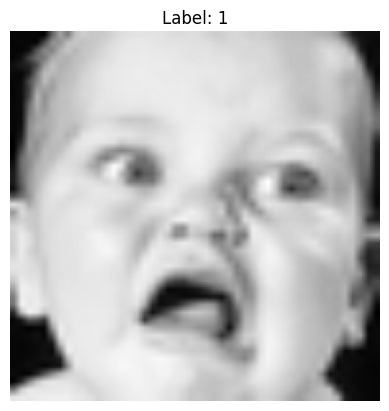

In [45]:
# Ambil satu contoh dari train_dataset
image, label = train_dataset[0]  # Index pertama dataset

# Jika transform menghasilkan tensor, konversi ke format numpy
if isinstance(image, torch.Tensor):
    image = image.permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C)

# Plot gambar
plt.imshow(image, cmap='gray')  # Gunakan cmap='gray' jika gambar grayscale
plt.title(f"Label: {label}")
plt.axis('off')  # Hilangkan sumbu
plt.show()

In [46]:
image, label = train_dataset[0]
image.shape

torch.Size([1, 224, 224])

## Build Vision Transformer (ViT) Model

In [47]:
from torch import nn

In [48]:
class PatchEmbedding(nn.Module):
    def __init__(self, 
                 in_channels:int=1,
                 patch_size:int=16,
                 embedding_dim:int=768 #16x16x3 -> color channels
                ):
        super().__init__()
        
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        self.flatten = nn.Flatten(start_dim=2,
                                  end_dim=3)

    def forward(self, x):
        image_resolution = x.shape[-1]
#         assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"
        
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched) 
        
        return x_flattened.permute(0, 2, 1) 

In [49]:
class MultiheadSelfAttentionBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768,
                 num_heads:int=12,
                 attn_dropout:float=0):
        super().__init__()
        
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True)
        
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x,
                                             key=x,
                                             value=x,
                                             need_weights=False)
        return attn_output

In [50]:
class MLPBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768,
                 mlp_size:int=3072,
                 dropout:float=0.1):
        super().__init__()
        
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size,
                      out_features=embedding_dim),
            nn.Dropout(p=dropout)
        )
    
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [51]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768,
                 num_heads:int=12,
                 mlp_size:int=3072,
                 mlp_dropout:float=0.1,
                 attn_dropout:float=0):
        super().__init__()

        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)
        
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)
         
    def forward(self, x):
        x = self.msa_block(x) + x 
        
        x = self.mlp_block(x) + x 
        
        return x

In [52]:
class ViT(nn.Module):
    def __init__(self,
                 img_size:int=224, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0, # Dropout for attention projection
                 mlp_dropout:float=0.1, # Dropout for dense/MLP layers 
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=1000): # Default for ImageNet but can customize this
        super().__init__() # don't forget the super().__init__()!
         
#         assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."
        
        self.num_patches = (img_size * img_size) // patch_size**2
                 
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)
        
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)
                
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
        
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
       
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, 
                      out_features=num_classes)
        )
    
    def forward(self, pixel_values, labels=None):
        
        batch_size = pixel_values.shape[0]
        
        class_token = self.class_embedding.expand(batch_size, -1, -1)

        x = self.patch_embedding(pixel_values)

        x = torch.cat((class_token, x), dim=1)

        x = self.position_embedding + x

        x = self.embedding_dropout(x)

        x = self.transformer_encoder(x)

        logits = self.classifier(x[:, 0])

        # Jika labels diberikan, hitung loss
        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)
    
        return (loss, logits) if loss is not None else logits

## Model Training

In [53]:
vit = ViT(num_classes=len(class_names), in_channels=1)

In [54]:
from torchinfo import summary

summary(
    model=vit,
    input_size=(1, 1, 224, 224),  # (batch_size, in_channels, img_size, img_size)
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=15,
    row_settings=["var_names"],
)

Layer (type (var_name))                                      Input Shape     Output Shape    Param #         Trainable
ViT (ViT)                                                    [1, 1, 224, 224] [1, 7]          152,064         True
├─PatchEmbedding (patch_embedding)                           [1, 1, 224, 224] [1, 196, 768]   --              True
│    └─Conv2d (patcher)                                      [1, 1, 224, 224] [1, 768, 14, 14] 197,376         True
│    └─Flatten (flatten)                                     [1, 768, 14, 14] [1, 768, 196]   --              --
├─Dropout (embedding_dropout)                                [1, 197, 768]   [1, 197, 768]   --              --
├─Sequential (transformer_encoder)                           [1, 197, 768]   [1, 197, 768]   --              True
│    └─TransformerEncoderBlock (0)                           [1, 197, 768]   [1, 197, 768]   --              True
│    │    └─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]   [1, 1

### Hitung Class Weight

In [55]:
from sklearn.utils.class_weight import compute_class_weight

train_labels = data_train["emotion"]
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
weight = dict(zip(np.unique(train_labels), class_weights))
print(weight)

class_weights = torch.tensor(class_weights, dtype=torch.float32)

{np.int64(0): np.float64(1.1735968998998563), np.int64(1): np.float64(1.3074945428086344), np.int64(2): np.float64(1.1735968998998563), np.int64(3): np.float64(0.6267206101190477), np.int64(4): np.float64(1.049774108116529), np.int64(5): np.float64(1.1739547038327527), np.int64(6): np.float64(0.8841725438740364)}


In [56]:
class ViTWithClassWeights(nn.Module):
    """Vision Transformer dengan class weights untuk menangani data tidak seimbang."""
    def __init__(self, base_vit, class_weights):
        super().__init__()
        self.vit = base_vit
        self.class_weights = class_weights
        self.loss_fn = nn.CrossEntropyLoss(weight=self.class_weights)

    def forward(self, pixel_values, labels=None):
        # Forward pass melalui model dasar
        outputs = self.vit(pixel_values)  # Memanggil ViT asli
        logits = outputs if isinstance(outputs, torch.Tensor) else outputs.logits

        # Jika labels tersedia, hitung loss
        loss = None
        if labels is not None:
            loss = self.loss_fn(logits, labels)

        return {"loss": loss, "logits": logits} if loss is not None else logits

In [57]:
vit_with_weights = ViTWithClassWeights(base_vit=vit, class_weights=class_weights)

In [58]:
from transformers import TrainerCallback, TrainingArguments, Trainer

# Callback untuk menyimpan model terbaik dan loss
class SaveBestModelCallback(TrainerCallback):
    def __init__(self, save_path, metric_name='eval_accuracy'):
        super().__init__()
        self.best_metric = -float('inf')  # Menyimpan metrik terbaik
        self.metric_name = metric_name
        self.save_path = save_path
        self.train_losses = []  # Menyimpan training loss per epoch
        self.eval_losses = []   # Menyimpan validation loss per epoch
        self.accuracies = []  # Menyimpan accuracy per epoch
        os.makedirs(self.save_path, exist_ok=True)
    
    def on_evaluate(self, args, state, control, metrics, **kwargs):
        if 'eval_loss' in metrics:
            self.eval_losses.append(metrics['eval_loss'])
        if 'eval_accuracy' in metrics:
            self.accuracies.append(metrics['eval_accuracy'])
        # Periksa apakah metrik saat ini lebih baik dari yang terbaik
        if self.metric_name in metrics and metrics[self.metric_name] > self.best_metric:
            self.best_metric = metrics[self.metric_name]
            model_path = os.path.join(self.save_path, "classWeight_best_model.pt")
            torch.save(kwargs['model'].state_dict(), model_path)
            print(f"Model terbaik disimpan di {model_path} dengan {self.metric_name}: {self.best_metric:.4f}")
    
    def on_epoch_end(self, args, state, control, **kwargs):
        # Ambil training loss dan accuracy dari log_history
        if state.log_history:
            if "loss" in state.log_history[-1]:
                self.train_losses.append(state.log_history[-1]["loss"])

        # Simpan grafik loss
        loss_path = os.path.join(self.save_path, "classWeight_loss_plot.png")
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, len(self.train_losses) + 1), self.train_losses, label="Training Loss", marker='o')
        if self.eval_losses:
            plt.plot(range(1, len(self.eval_losses) + 1), self.eval_losses, label="Validation Loss", marker='o')
        plt.title("Loss per Epoch")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)
        plt.savefig(loss_path)
        plt.close()
        print(f"Grafik loss disimpan untuk epoch {state.epoch}")
        
        # Simpan grafik accuracy
        accuracy_path = os.path.join(self.save_path, "classWeight_accuracy_plot.png")
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, len(self.accuracies) + 1), self.accuracies, label="Accuracy", marker='o')
        plt.title("Accuracy per Epoch")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.grid(True)
        plt.savefig(accuracy_path)
        plt.close()
        print(f"Grafik accuracy disimpan untuk epoch {state.epoch}")

In [59]:
training_args = TrainingArguments(
    output_dir="../Khaairi/Result",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    evaluation_strategy="epoch",
    save_strategy="no",
    logging_steps=100,
    num_train_epochs=1000,
    learning_rate=3e-4,
    remove_unused_columns=False,
)

/home/ilkom/.local/lib/python3.12/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [60]:
def collate_fn(batch):
    pixel_values = torch.stack([x[0] for x in batch])  # Mengambil pixel_values (index 0)
    labels = torch.tensor([x[1] for x in batch])       # Mengambil labels (index 1)
    return {
        'pixel_values': pixel_values,
        'labels': labels
    }

In [61]:
import evaluate

# Memuat metrik
accuracy = evaluate.load('accuracy')
f1 = evaluate.load('f1')

# Fungsi untuk menghitung metrik
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=1)

    # Menghitung accuracy
    accuracy_score = accuracy.compute(predictions=predictions, references=labels)

    # Menghitung F1 score
    f1_score = f1.compute(predictions=predictions, references=labels, average='weighted')

    # Menggabungkan kedua metrik
    metrics = {
        'accuracy': accuracy_score['accuracy'],
        'f1': f1_score['f1']
    }

    return metrics

In [62]:
trainer = Trainer(
    model=vit_with_weights,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    callbacks=[SaveBestModelCallback(save_path = '../Khaairi/Result')]
)

In [29]:
trainer.train()

/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.946700,1.921061,0.219366,0.169491
2,1.917700,1.932565,0.183639,0.112057
3,1.891900,1.868968,0.261102,0.202825
4,1.869900,1.876127,0.228715,0.217722
5,1.851500,1.860652,0.223038,0.167672
6,1.862700,1.839346,0.269449,0.239981
7,1.860700,1.865745,0.241068,0.222737
8,1.850200,1.842233,0.231720,0.220214
9,1.841100,1.846302,0.235392,0.225493
10,1.843800,1.865809,0.247412,0.224787


Grafik loss disimpan untuk epoch 1.0
Grafik accuracy disimpan untuk epoch 1.0
Model terbaik disimpan di ../Khaairi/Result/base_best_model.pt dengan eval_accuracy: 0.2194


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 2.0
Grafik accuracy disimpan untuk epoch 2.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 3.0
Grafik accuracy disimpan untuk epoch 3.0
Model terbaik disimpan di ../Khaairi/Result/base_best_model.pt dengan eval_accuracy: 0.2611


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 4.0
Grafik accuracy disimpan untuk epoch 4.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 5.0
Grafik accuracy disimpan untuk epoch 5.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 6.0
Grafik accuracy disimpan untuk epoch 6.0
Model terbaik disimpan di ../Khaairi/Result/base_best_model.pt dengan eval_accuracy: 0.2694


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 7.0
Grafik accuracy disimpan untuk epoch 7.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 8.0
Grafik accuracy disimpan untuk epoch 8.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 9.0
Grafik accuracy disimpan untuk epoch 9.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 10.0
Grafik accuracy disimpan untuk epoch 10.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 11.0
Grafik accuracy disimpan untuk epoch 11.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 12.0
Grafik accuracy disimpan untuk epoch 12.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 13.0
Grafik accuracy disimpan untuk epoch 13.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 14.0
Grafik accuracy disimpan untuk epoch 14.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 15.0
Grafik accuracy disimpan untuk epoch 15.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 16.0
Grafik accuracy disimpan untuk epoch 16.0
Model terbaik disimpan di ../Khaairi/Result/base_best_model.pt dengan eval_accuracy: 0.2841


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 17.0
Grafik accuracy disimpan untuk epoch 17.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 18.0
Grafik accuracy disimpan untuk epoch 18.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 19.0
Grafik accuracy disimpan untuk epoch 19.0
Model terbaik disimpan di ../Khaairi/Result/base_best_model.pt dengan eval_accuracy: 0.2858


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 20.0
Grafik accuracy disimpan untuk epoch 20.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 21.0
Grafik accuracy disimpan untuk epoch 21.0
Model terbaik disimpan di ../Khaairi/Result/base_best_model.pt dengan eval_accuracy: 0.2861


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 22.0
Grafik accuracy disimpan untuk epoch 22.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 23.0
Grafik accuracy disimpan untuk epoch 23.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 24.0
Grafik accuracy disimpan untuk epoch 24.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 25.0
Grafik accuracy disimpan untuk epoch 25.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 26.0
Grafik accuracy disimpan untuk epoch 26.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 27.0
Grafik accuracy disimpan untuk epoch 27.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 28.0
Grafik accuracy disimpan untuk epoch 28.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 29.0
Grafik accuracy disimpan untuk epoch 29.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 30.0
Grafik accuracy disimpan untuk epoch 30.0
Model terbaik disimpan di ../Khaairi/Result/base_best_model.pt dengan eval_accuracy: 0.2948


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 31.0
Grafik accuracy disimpan untuk epoch 31.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Model terbaik disimpan di ../Khaairi/Result/base_best_model.pt dengan eval_accuracy: 0.3119


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 33.0
Grafik accuracy disimpan untuk epoch 33.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 34.0
Grafik accuracy disimpan untuk epoch 34.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 35.0
Grafik accuracy disimpan untuk epoch 35.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 36.0
Grafik accuracy disimpan untuk epoch 36.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 37.0
Grafik accuracy disimpan untuk epoch 37.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 38.0
Grafik accuracy disimpan untuk epoch 38.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 39.0
Grafik accuracy disimpan untuk epoch 39.0
Model terbaik disimpan di ../Khaairi/Result/base_best_model.pt dengan eval_accuracy: 0.3222


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 40.0
Grafik accuracy disimpan untuk epoch 40.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 41.0
Grafik accuracy disimpan untuk epoch 41.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 42.0
Grafik accuracy disimpan untuk epoch 42.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 43.0
Grafik accuracy disimpan untuk epoch 43.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 44.0
Grafik accuracy disimpan untuk epoch 44.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 45.0
Grafik accuracy disimpan untuk epoch 45.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 46.0
Grafik accuracy disimpan untuk epoch 46.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 47.0
Grafik accuracy disimpan untuk epoch 47.0
Grafik loss disimpan untuk epoch 48.0
Grafik accuracy disimpan untuk epoch 48.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 49.0
Grafik accuracy disimpan untuk epoch 49.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 50.0
Grafik accuracy disimpan untuk epoch 50.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 51.0
Grafik accuracy disimpan untuk epoch 51.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 52.0
Grafik accuracy disimpan untuk epoch 52.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 53.0
Grafik accuracy disimpan untuk epoch 53.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 54.0
Grafik accuracy disimpan untuk epoch 54.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 55.0
Grafik accuracy disimpan untuk epoch 55.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 56.0
Grafik accuracy disimpan untuk epoch 56.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 57.0
Grafik accuracy disimpan untuk epoch 57.0
Model terbaik disimpan di ../Khaairi/Result/base_best_model.pt dengan eval_accuracy: 0.3279


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 58.0
Grafik accuracy disimpan untuk epoch 58.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 59.0
Grafik accuracy disimpan untuk epoch 59.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 60.0
Grafik accuracy disimpan untuk epoch 60.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 61.0
Grafik accuracy disimpan untuk epoch 61.0
Model terbaik disimpan di ../Khaairi/Result/base_best_model.pt dengan eval_accuracy: 0.3285


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 62.0
Grafik accuracy disimpan untuk epoch 62.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 63.0
Grafik accuracy disimpan untuk epoch 63.0
Model terbaik disimpan di ../Khaairi/Result/base_best_model.pt dengan eval_accuracy: 0.3336


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 64.0
Grafik accuracy disimpan untuk epoch 64.0
Model terbaik disimpan di ../Khaairi/Result/base_best_model.pt dengan eval_accuracy: 0.3426


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 65.0
Grafik accuracy disimpan untuk epoch 65.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 66.0
Grafik accuracy disimpan untuk epoch 66.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 67.0
Grafik accuracy disimpan untuk epoch 67.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 68.0
Grafik accuracy disimpan untuk epoch 68.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 69.0
Grafik accuracy disimpan untuk epoch 69.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 70.0
Grafik accuracy disimpan untuk epoch 70.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 71.0
Grafik accuracy disimpan untuk epoch 71.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 72.0
Grafik accuracy disimpan untuk epoch 72.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 73.0
Grafik accuracy disimpan untuk epoch 73.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 74.0
Grafik accuracy disimpan untuk epoch 74.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 75.0
Grafik accuracy disimpan untuk epoch 75.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 76.0
Grafik accuracy disimpan untuk epoch 76.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 77.0
Grafik accuracy disimpan untuk epoch 77.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 78.0
Grafik accuracy disimpan untuk epoch 78.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 79.0
Grafik accuracy disimpan untuk epoch 79.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 80.0
Grafik accuracy disimpan untuk epoch 80.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 81.0
Grafik accuracy disimpan untuk epoch 81.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 82.0
Grafik accuracy disimpan untuk epoch 82.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 83.0
Grafik accuracy disimpan untuk epoch 83.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 84.0
Grafik accuracy disimpan untuk epoch 84.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 85.0
Grafik accuracy disimpan untuk epoch 85.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 86.0
Grafik accuracy disimpan untuk epoch 86.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 87.0
Grafik accuracy disimpan untuk epoch 87.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 88.0
Grafik accuracy disimpan untuk epoch 88.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 89.0
Grafik accuracy disimpan untuk epoch 89.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 90.0
Grafik accuracy disimpan untuk epoch 90.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 91.0
Grafik accuracy disimpan untuk epoch 91.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 92.0
Grafik accuracy disimpan untuk epoch 92.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 93.0
Grafik accuracy disimpan untuk epoch 93.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 94.0
Grafik accuracy disimpan untuk epoch 94.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 95.0
Grafik accuracy disimpan untuk epoch 95.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 96.0
Grafik accuracy disimpan untuk epoch 96.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 97.0
Grafik accuracy disimpan untuk epoch 97.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 98.0
Grafik accuracy disimpan untuk epoch 98.0


/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Grafik loss disimpan untuk epoch 99.0
Grafik accuracy disimpan untuk epoch 99.0


KeyboardInterrupt: 

In [30]:
trainer.evaluate(test_dataset)

{'eval_loss': 2.1677916049957275,
 'eval_accuracy': 0.31430288461538464,
 'eval_f1': 0.3174491441783137}

In [31]:
# Melakukan prediksi pada dataset validasi
predictions = trainer.predict(test_dataset)

# Mendapatkan logits dan label sebenarnya
logits = predictions.predictions
labels = predictions.label_ids

# Mendapatkan prediksi akhir dengan argmax
y_pred = np.argmax(logits, axis=1)
y_true = labels

/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


<Figure size 1200x1000 with 0 Axes>

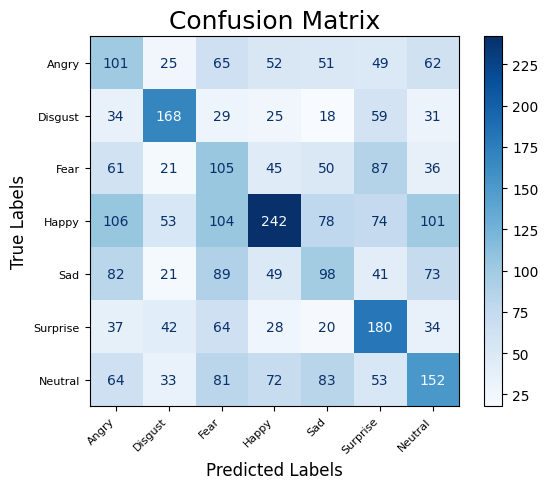

In [32]:
# Menghitung Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Mengatur ukuran gambar
plt.figure(figsize=(12, 10))

# Menampilkan Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(id2label.values()))
disp.plot(cmap=plt.cm.Blues, values_format='d')

# Mengatur judul dan ukuran font
plt.title("Confusion Matrix", fontsize=18)
plt.xticks(rotation=45, ha='right', fontsize=8)  # Ukuran font lebih kecil untuk sumbu x
plt.yticks(fontsize=8)  # Ukuran font lebih kecil untuk sumbu y
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)

# Tampilkan plot
plt.show()

## Load Best Model

In [68]:
vit_with_weights2 = ViTWithClassWeights(base_vit=vit, class_weights=class_weights)

In [69]:
# Load state_dict
model_path = "../Khaairi/Result/base_best_model.pt"
vit_with_weights2.load_state_dict(torch.load(model_path))

/tmp/ipykernel_473924/481160473.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vit_with_weights2.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [70]:
trainer = Trainer(
    model=vit_with_weights2,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    callbacks=[SaveBestModelCallback(save_path = '../Khaairi/Result')]
)

In [71]:
trainer.evaluate(test_dataset)

/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Model terbaik disimpan di ../Khaairi/Result/base_best_model.pt dengan eval_accuracy: 0.3323


{'eval_loss': 1.7292253971099854,
 'eval_accuracy': 0.3323317307692308,
 'eval_f1': 0.3225574247506593,
 'eval_runtime': 28.3887,
 'eval_samples_per_second': 117.23,
 'eval_steps_per_second': 3.663}

In [72]:
# Melakukan prediksi pada dataset validasi
predictions = trainer.predict(test_dataset)

# Mendapatkan logits dan label sebenarnya
logits = predictions.predictions
labels = predictions.label_ids

# Mendapatkan prediksi akhir dengan argmax
y_pred = np.argmax(logits, axis=1)
y_true = labels

/home/ilkom/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


<Figure size 1200x1000 with 0 Axes>

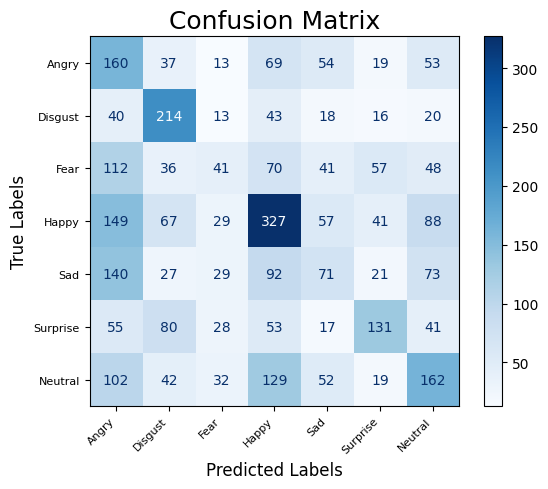

In [73]:
# Menghitung Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Mengatur ukuran gambar
plt.figure(figsize=(12, 10))

# Menampilkan Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(id2label.values()))
disp.plot(cmap=plt.cm.Blues, values_format='d')

# Mengatur judul dan ukuran font
plt.title("Confusion Matrix", fontsize=18)
plt.xticks(rotation=45, ha='right', fontsize=8)  # Ukuran font lebih kecil untuk sumbu x
plt.yticks(fontsize=8)  # Ukuran font lebih kecil untuk sumbu y
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)

# Tampilkan plot
plt.show()